In [116]:
import scipy.io

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

In [117]:
PATH = '/home/ravi/Models-of-Working-Memory/b_data/matlab_code/P00_data_behavior'

In [118]:
pat = scipy.io.loadmat(f'{PATH}/b_data_subject_1')

In [119]:
def build_tile_df(N=20):
    dfs = []
    for i in range(N):
        pat = scipy.io.loadmat(f'{PATH}/b_data_subject_{i+1}')
        pat = pat['b_data'][0]
        match = pat[0][1].flatten()
        random_match = pat[1][1].flatten()
        tile_clicked = pat[11][1].flatten()[1::2]
        board_size = pat[6][1].flatten()[1::2]
        correct_tile = pat[12][1].flatten()[0::2]
        nslc = pat[3][1].flatten()[1::2]
        nsp = pat[2][1].flatten()[1::2]

        categories = {0: 'z', 1: 'animal', 2: 'food', 3: 'indoor', 4: 'person', 5: 'vehicle'}        
        img_category = pat[10][1].flatten()
        img_category = np.vectorize(categories.get)(img_category)

        dfs.append(pd.DataFrame({
            'match': match,
            'random_match': random_match,
            'tile_clicked': tile_clicked-1,
            'board_size': board_size,
            'correct_tile': correct_tile-1,
            'clicked_category': img_category[1::2],
            'corr_category': img_category[0::2],
            'nslc': nslc,
            'nsp': nsp,
            'patient': i+1,
        }))
    return pd.concat(dfs).reset_index(drop=True)

In [120]:
df = build_tile_df()

# Heatmaps

In [121]:
def plot_error_location(df, match):
    mm_df = df[df['match'] == match]
    mm_df = mm_df[mm_df['correct_tile'] >= 0]
    b_grouped = mm_df.groupby('board_size')
    for board_size, b_group in b_grouped:
        N = int(np.sqrt(board_size))
        counts = np.bincount(b_group['tile_clicked'].to_numpy(), minlength=board_size)
        input = np.reshape(counts/counts.sum(), (N, N))
        plt.figure() 
        lab = ['Mismatch', 'Match']
        sns.heatmap(input, annot=True, cmap='magma', square=True, cbar=True, cbar_kws={'label': f'{lab[match]} Frequency', 'format': '%.3f'}) 

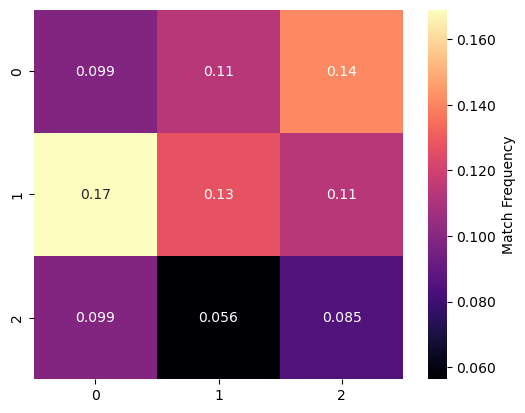

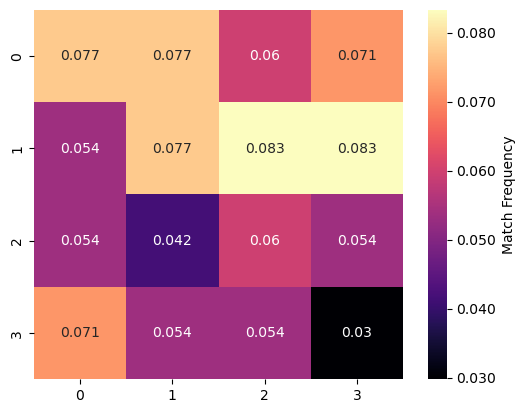

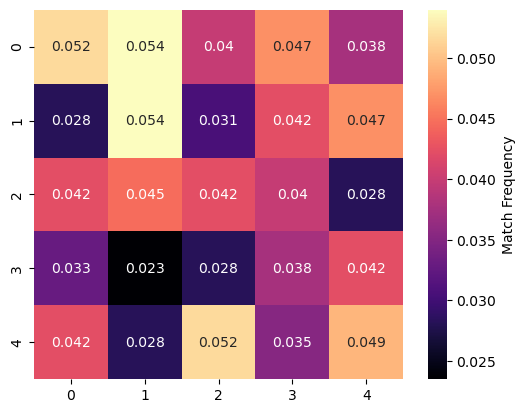

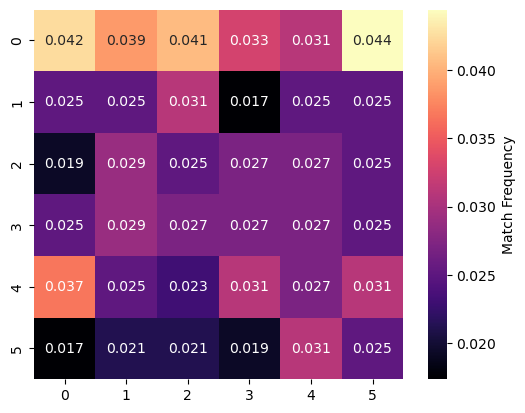

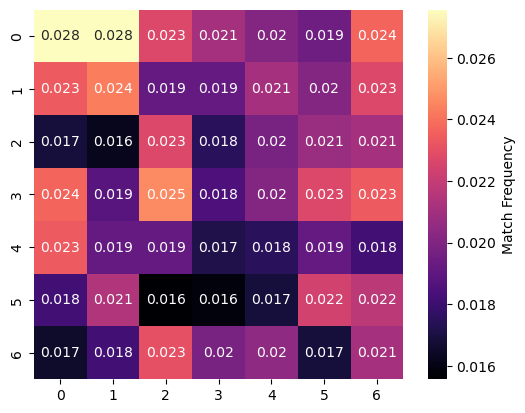

In [131]:
plot_error_location(df, 1)

In [123]:
def plot_error_location_diff(df):
    b_grouped = df.groupby('board_size')
    for board_size, b_group in b_grouped:
        N = int(np.sqrt(board_size))
        m_df = b_group[b_group['match']==1]
        m_df = m_df[m_df['correct_tile'] >= 0]
        m_counts = np.bincount(m_df['tile_clicked'].to_numpy(), minlength=board_size)
        mm_df = b_group[b_group['match']==0]
        mm_df = mm_df[mm_df['correct_tile'] >= 0]
        mm_counts = np.bincount(mm_df['tile_clicked'].to_numpy(), minlength=board_size)
        input = np.reshape((mm_counts/mm_counts.sum()) - (m_counts/m_counts.sum()), (N, N))
        plt.figure() 
        sns.heatmap(input, annot=False, cmap='coolwarm', square=True, cbar=True, cbar_kws={'label': 'Match v Mismatch Frequency', 'format': '%.3f'})

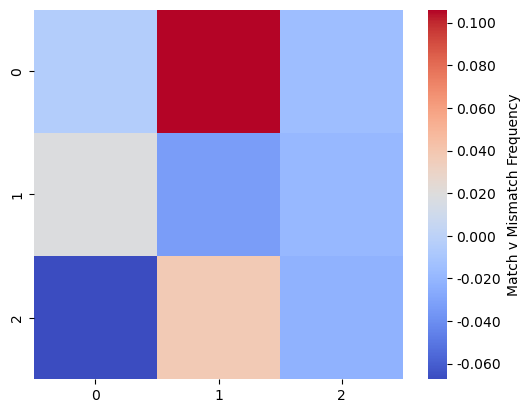

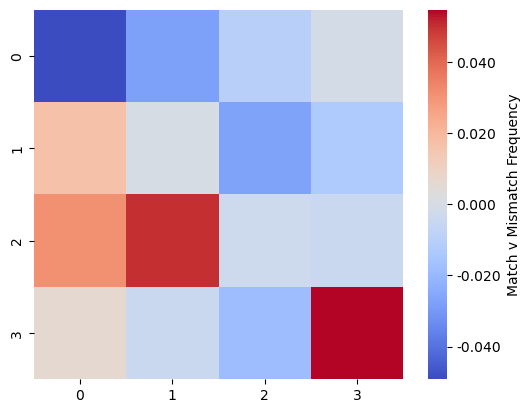

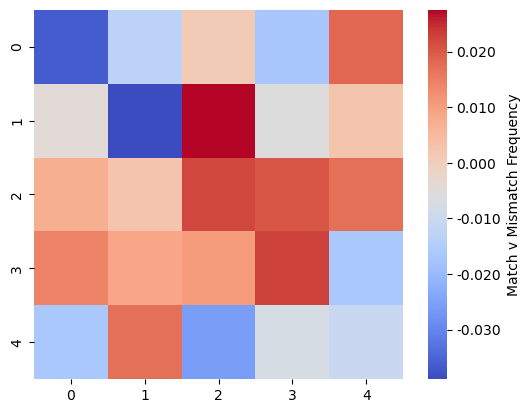

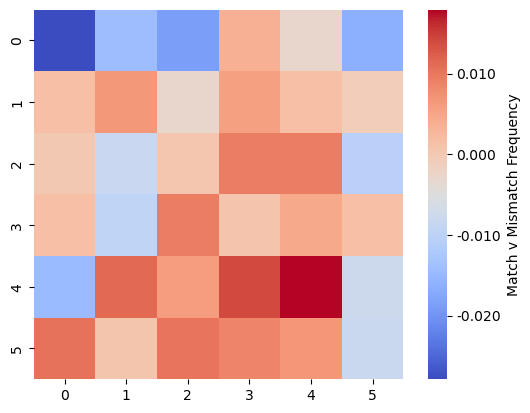

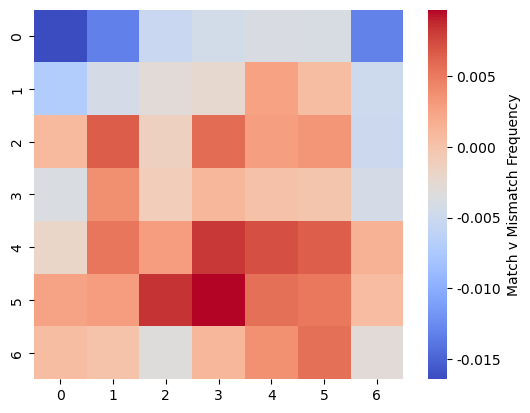

In [124]:
plot_error_location_diff(df)

# Positional distance

In [125]:
def euclidean_distance(row):
    N = int(np.sqrt(row['board_size']))
    # Convert 1D indices to 2D coordinates
    x1, y1 = np.unravel_index(row['tile_clicked'], (N, N))
    x2, y2 = np.unravel_index(row['correct_tile'], (N, N))
    
    # Compute Euclidean distance
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    return distance

In [126]:
def plot_error_distance(df):
    mm_df = df[df['match'] == 0]
    mm_df = mm_df[mm_df['random_match'] == 0]
    mm_df = mm_df[mm_df['correct_tile'] >= 0]
    mm_df['distance'] = mm_df.apply(euclidean_distance, axis=1)
    mm_df['board_size'] = mm_df['board_size'].apply(np.sqrt)
    plt.figure(figsize=(8, 16))
    palette = ['grey']
    ax = sns.catplot(x="board_size", y="distance", data=mm_df, aspect=0.85, kind='bar', palette=palette)
    ax.set(xlabel="Board size", ylabel="distance-from-correct")
    plt.show()

<Figure size 800x1600 with 0 Axes>

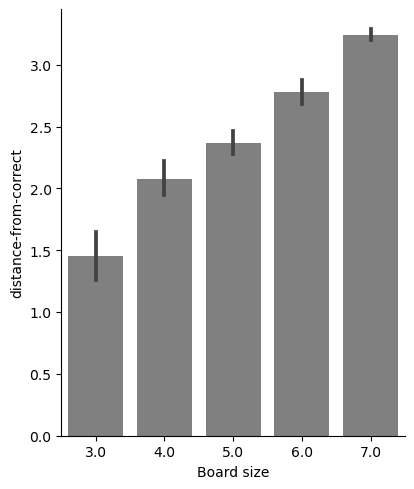

In [127]:
plot_error_distance(df)

# Categorical error

In [128]:
def plot_error_category(df):
    b_grouped = df.groupby('board_size')
    for board_size, b_group in b_grouped:
        b_df = b_group[b_group['match']==0]
        b_df = b_df[b_df['correct_tile']>=0]
        co_occurrence_matrix = pd.crosstab(b_df['clicked_category'], b_df['corr_category']) / len(b_df)
        plt.figure()
        ax = sns.heatmap(co_occurrence_matrix, annot=False, cmap='magma', square=True, cbar=True, cbar_kws={'label': f'Error frequency (Board size: {board_size})', 'format': '%.3f'})
        ax.set(xlabel="Correct category", ylabel="Selected category")

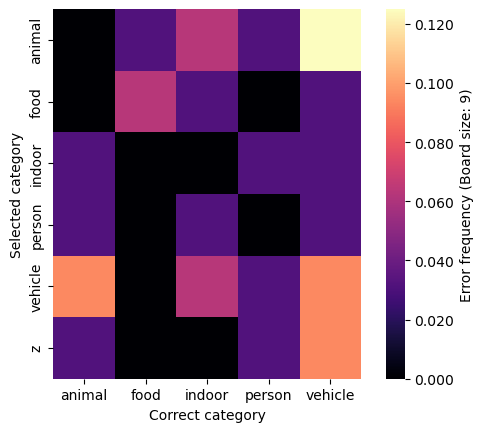

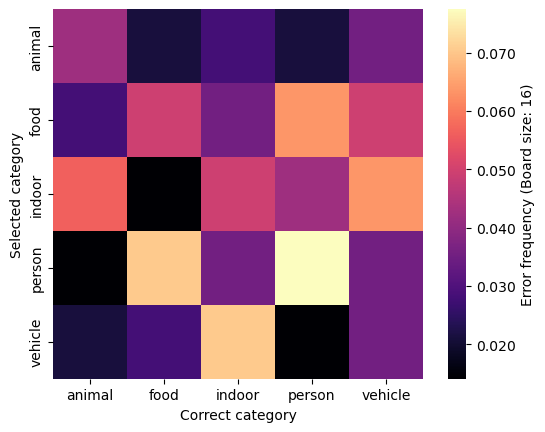

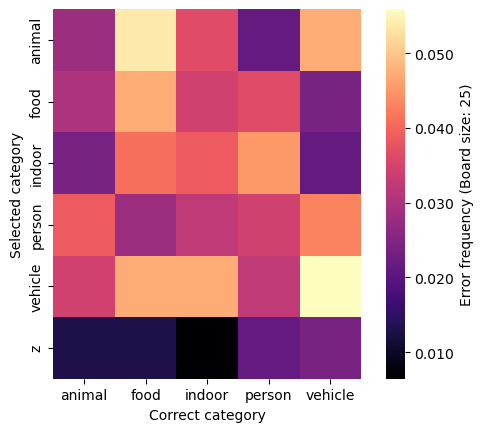

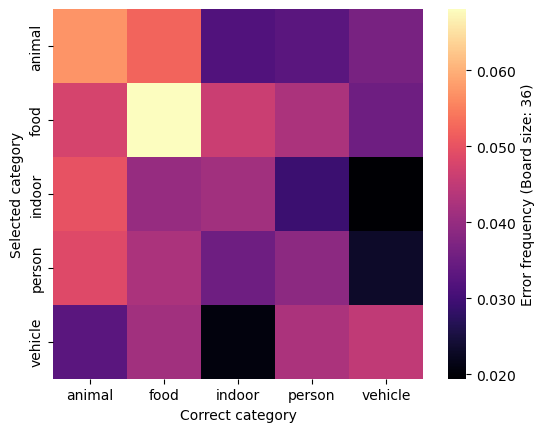

In [129]:
plot_error_category(df)